In [1]:
import sys
import re
import os
from pathlib import Path
from collections import namedtuple
import numpy as np

### Taking data set from Seeval 2016 - task 5 subset 1 : http://alt.qcri.org/semeval2016/task5/

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import re
import ast
pd.set_option('display.max_colwidth' , -1)

### English Laptop domain training data

In [3]:
eng_multi_aspects = pd.read_csv('../data/English_laptops.csv')
eng_multi_aspects['aspects'] = eng_multi_aspects['aspects'].apply(lambda x: ast.literal_eval(x))
eng_multi_aspects['polarities'] = eng_multi_aspects['polarities'].apply(lambda x: ast.literal_eval(x))
#eng_multi_aspects.head(2)

In [4]:
eng_multi_aspects[['text'  , 'aspects' , 'polarities']].head()

,text,aspects,polarities
0,This computer is absolutely AMAZING!!!,[LAPTOP#GENERAL],[positive]
1,10 plus hours of battery...,[BATTERY#OPERATION_PERFORMANCE],[positive]
2,super fast processor and really nice graphics card..,"[CPU#OPERATION_PERFORMANCE, GRAPHICS#GENERAL]","[positive, positive]"
3,and plenty of storage with 250 gb(though I will upgrade this and the ram..),[HARD_DISC#DESIGN_FEATURES],[positive]
4,This computer is really fast and I'm shocked as to how easy it is to get used to...,"[LAPTOP#OPERATION_PERFORMANCE, LAPTOP#USABILITY]","[positive, positive]"


In [5]:
eng_single_aspects = eng_multi_aspects[eng_multi_aspects['aspects'].apply(lambda x: len(x))==1]
#eng_single_aspects['polarities']= eng_single_aspects['polarities'].apply(lambda x: x[0])
#eng_single_aspects['aspects']= eng_single_aspects['aspects'].apply(lambda x: x[0])
eng_single_aspects.drop(['aspects'] , axis = 1 , inplace=True)

/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Chinese data in Mobile and Camera domain 

In [120]:
eng_single_aspects['polarities'] = eng_single_aspects['polarities'].apply(lambda x: x[0])

In [122]:
eng_single_aspects[['text', 'polarities']].tail()

,text,polarities
2031,do not use the facial recognition,negative
2032,Windows 8 is not supported by a lot of things!,negative
2034,It does what it advertises.,positive
2036,"I would recommend it, for anybody needing a reliable simple laptop.",positive
2038,Love the price too!,positive


In [6]:
zu_camera_df = pd.read_csv('../data/Chinese_camera.csv')
zu_camera_df['aspects'] = zu_camera_df['aspects'].apply(lambda x: ast.literal_eval(x))
zu_camera_df['polarities'] = zu_camera_df['polarities'].apply(lambda x: ast.literal_eval(x))
#zu_camera_df['polarities'] = zu_camera_df['polarities'].apply(lambda x: x[0])
zu_camera_df.drop(['aspects'] , axis = 1 , inplace = True)

In [7]:
zu_mobile_df = pd.read_csv('../data/Chinese_phones.csv')

In [8]:
zu_mobile_df['aspects']  = zu_mobile_df['aspects'].apply(lambda x: ast.literal_eval(x))
zu_mobile_df['polarities'] = zu_mobile_df['polarities'].apply(lambda x: ast.literal_eval(x))

In [9]:
#zu_mobile_df['polarities'] = zu_mobile_df['polarities'].apply(lambda x : x[0])
zu_mobile_df.drop(['aspects'] , axis = 1 , inplace=True)

#### We will extract embeddings for text column using https://github.com/facebookresearch/LASER . Saving text column separately for this.

In [10]:
#"en" ,"nl", 'es'
eng_single_aspects[['text']].to_csv('../data/tatoeba/v1/en_laptop.txt' , header = None , index = None , mode = 'w')
zu_camera_df[['text']].to_csv('../data/tatoeba/v1/zh_camera.txt' , header = None , index = None , mode = 'w')
zu_mobile_df[['text']].to_csv('../data/tatoeba/v1/zh_mobile.txt' , header = None , index = None , mode = 'w')

In [10]:
LASER_PATH = ".."
sys.path.append(LASER_PATH + '/source')
sys.path.append(LASER_PATH + '/source/lib')

DATA_PATH = Path("../data/tatoeba/v1/")
CACHE_PATH = Path("cache/")
CACHE_PATH.mkdir(exist_ok=True)
MODEL_PATH = Path("../models")

os.environ["LASER"] = LASER_PATH 
SPACE_NORMALIZER = re.compile("\s+")
Batch = namedtuple('Batch', 'srcs tokens lengths')

In [11]:
from indexing import IndexLoad, IndexTextOpen, IndexTextQuery, IndexSearchKNN, IndexCreate, IndexSearchMultiple
from embed import SentenceEncoder, EncodeLoad, EncodeFile
from text_processing import Token, BPEfastApply

#### Following steps from https://medium.com/the-artificial-impostor/multilingual-similarity-search-using-pretrained-bidirectional-lstm-encoder-e34fac5958b0 for tokenization , BPE Fast and Embedding extractions 

In [14]:
eng_single_aspects = eng_single_aspects[~eng_single_aspects['polarities'].apply(lambda x: 'neutral' in x)]
eng_single_aspects.shape , zu_camera_df.shape , zu_mobile_df.shape

((1284, 2), (1259, 2), (1333, 2))

In [14]:
#eng_single_aspects[['text']].to_csv('../data/tatoeba/v1/en_laptop.txt' , header = None , index = None , mode = 'w')

In [32]:
#"en" ,"nl", 'es'

encoder = SentenceEncoder(
    str(MODEL_PATH / "bilstm.93langs.2018-12-26.pt"),
    max_sentences=None,
    max_tokens=10000,
    cpu=False)
bpe_codes = str(MODEL_PATH / "93langs.fcodes")

for filename in ("en_laptop" ,"zh_camera", 'zh_mobile'):  ##"zh" for chinese , nl  for dutch and es for spanish
    lang = filename[0:2]
    Token(
        str(DATA_PATH / f"{filename}.txt"), ##english_resturant.txt
        str(CACHE_PATH / f"{filename}.txt"),
        lang=lang,
        romanize=False,
        lower_case=True, gzip=False,
        verbose=True)
    BPEfastApply(
        str(CACHE_PATH / f"{filename}.txt"),
        str(CACHE_PATH / f"{filename}.bpe"),
        bpe_codes,
        verbose=True, over_write=True)
    EncodeFile(
        encoder,
        str(CACHE_PATH / f"{filename}.bpe"),
        str(CACHE_PATH / f"{filename}.enc"),
        verbose=True, over_write=True)    

 - Tokenizer: en_laptop.txt in language en  
 - fast BPE: processing en_laptop.txt
 - Encoder: en_laptop.bpe to en_laptop.enc
 - Encoder: 1284 sentences in 0s
 - Tokenizer: zh_camera.txt exists already
 - Tokenizer: zh_mobile.txt exists already


## Extract Setence Embeddings

In [17]:
data_en, index_en = IndexCreate(
    str(CACHE_PATH / "en_laptop.enc"), 'FlatL2', verbose=True, save_index=False)
data_zh_cam, index_zh_cam = IndexCreate(
    str(CACHE_PATH / "zh_camera.enc"), 'FlatL2', verbose=True, save_index=False)
data_zh_mob, index_zh_mob = IndexCreate(
    str(CACHE_PATH / "zh_mobile.enc"), 'FlatL2', verbose=True, save_index=False)ding: cache/en_laptop.enc 1284 examples of dim 1024
 - creating FAISS index
 - embedding: cache/zh_camera.enc 1259 examples of dim 1024
 - creating FAISS index
 - embedding: cache/zh_mobile.enc 1333 examples of dim 1024
 - creating FAISS index

 - embedding: cache/en_laptop.enc 1284 examples of dim 1024
 - creating FAISS index
 - embedding: cache/zh_camera.enc 1259 examples of dim 1024
 - creating FAISS index
 - embedding: cache/zh_mobile.enc 1333 examples of dim 1024
 - creating FAISS index


##### Because dataset of semeval is not exact translation of each other , some of the above results are not good. 

### Creating multi label classification task using LASER sentence embedding. 
We can have 6 aspect categories , present for each review. We will train a simple 1 layer Neural Network model using 1024 dimensional sentence embedding as input and 6 categories as output.  
Train the model on 1700 English sentences and Validate on 1300 Dutch sentences . We are getting around 85 % accuracy and 57% f1 score(Macro) 

In [18]:
from sklearn.model_selection import train_test_split
train_aspects , val_aspects, train_df , val_df = train_test_split(eng_single_aspects , data_en , test_size = 0.2 , random_state = 42)

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb  = MultiLabelBinarizer()
tr_eng = train_aspects['polarities'].apply(lambda x: 1 if 'positive' in x else 0).values   #mlb.fit_transform(train_aspects.polarities)
val_eng =  val_aspects['polarities'].apply(lambda x: 1 if 'positive' in x else 0).values#mlb.transform(val_aspects.polarities)
zh_camera  =  zu_camera_df['polarities'].apply(lambda x: 1 if 'positive' in x else 0).values  #mlb.transform(zu_camera_df.polarities)
zh_mobile = zu_mobile_df['polarities'].apply(lambda x: 1 if 'positive' in x else 0).values #mlb.transform(zu_mobile_df.polarities)

In [22]:
val_eng.shape

(257,)

In [21]:
# train_aspects.reset_index(inplace=True , drop= True)
# train_fn = pd.merge(train_aspects , pd.DataFrame(tr_eng , columns=mlb.classes_) , left_index=True , right_index=True)

# val_aspects.reset_index(inplace=True , drop= True)
# val_fn = pd.merge(val_aspects , pd.DataFrame(val_eng , columns=mlb.classes_) , left_index=True , right_index=True)

# train_fn.drop(columns=['aspects2'] , inplace=True)
# val_fn.drop(columns=['aspects2'] , inplace=True)

# train_fn.to_csv('resturant_train_eng.csv' , index = False)
# val_fn.to_csv('resturant_val_eng.csv' , index = False)

In [23]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler().fit(train_df)
train_std = std_scale.transform(train_df) 
val_std = std_scale.transform(val_df)
test1_std = std_scale.transform(data_zh_cam)
test2_std = std_scale.transform(data_zh_mob)

In [24]:
train_std.shape , val_std.shape , test1_std.shape , test2_std.shape

((1027, 1024), (257, 1024), (1259, 1024), (1333, 1024))

In [40]:
import random 
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True

In [41]:
import torch 
import torch
import torch.nn as nn

x_train,y_train,x_valid,y_valid , x_test , y_test  , x_test2 , y_test2 = map(torch.FloatTensor, (train_std,tr_eng,  val_std ,\
                                                                            val_eng, test1_std,zh_camera, \
                                                                           test2_std ,zh_mobile ))
n,c = x_train.shape
y_train = y_train.type(torch.FloatTensor).view(-1 , 1)
y_valid = y_valid.type(torch.FloatTensor).view(-1 , 1)
y_test = y_test.type(torch.FloatTensor).view(-1 , 1)
y_test2 = y_test2.type(torch.FloatTensor).view(-1 , 1)

print(y_train.shape , y_valid.shape , y_test.shape , y_test2.shape)
print(x_train.shape , x_valid.shape , x_test.shape , x_test2.shape)
batch_size = 64

torch.Size([1027, 1]) torch.Size([257, 1]) torch.Size([1259, 1]) torch.Size([1333, 1])
torch.Size([1027, 1024]) torch.Size([257, 1024]) torch.Size([1259, 1024]) torch.Size([1333, 1024])


In [42]:
class Model(nn.Module):
    def __init__(self , p):
        super().__init__()
        self.hidden = nn.Linear(1024, 64)
#         self.hidden2 = nn.Linear(512 , 256)
#         self.hidden3 =  nn.Linear(256 , 128)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.activation(self.dropout(self.hidden(x)))
        x = self.fc(x)
        return x

In [43]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size , shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid )
valid_dl = DataLoader(valid_ds , batch_size= batch_size)

test_ds = TensorDataset(x_test , y_test)
test_dl = DataLoader(test_ds , batch_size=batch_size)

test_ds2 = TensorDataset(x_test2 , y_test2)
test_dl2 = DataLoader(test_ds2 , batch_size=batch_size)

In [44]:
class WrappedDataLoader():
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self): return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches: yield(self.func(*b))

In [45]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def preprocess(x,y): return x.to(dev),y.to(dev)

train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)
test_dl = WrappedDataLoader(test_dl , preprocess)
test_dl2 = WrappedDataLoader(test_dl2 , preprocess)

In [46]:

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.mean() #/ (len(correct))
    return acc


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(torch.sigmoid(y_pred).float(), threshold).float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum(dim=0)
    precision = true_positive.div(y_pred.sum(dim=0).add(eps))
    recall = true_positive.div(y_true.sum(dim=0).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))


def f1_score(y_pred,y_true, threshold=0.5):
    f1 = fbeta_score(y_true, y_pred, 1, threshold) #; print('f1 score' , f1)
    return f1

In [47]:
def train_model(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0  
    epoch_f1 = 0
    model.train()
    ct = 0
    for x, y in iterator:
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        acc = binary_accuracy(predictions, y)
        f1 = f1_score(predictions , y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1.item()  
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , epoch_f1/len(iterator)

In [48]:
def validate_model(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0 
    epoch_f1 = 0
    model.eval()
    with torch.no_grad():
        for x ,y  in iterator:

            predictions = model(x)#.squeeze(1)
            loss = criterion(predictions,y)
            acc = binary_accuracy(predictions, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1_score(predictions , y).item()
        
    return epoch_loss / len(iterator), epoch_acc /len(iterator) , epoch_f1/len(iterator) 

In [49]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

from torch import optim

### Apply grid search on LR , Weight Decay , Dropout parameters , save the parameters with best f1-score on validatation data .

In [50]:
best_valid_f1 = -float('inf')
loss_func = nn.BCEWithLogitsLoss()
loss_func = loss_func.to(dev)
for drp in [0.2, 0.3,0.4,0.5,0.6]:
    for wd in [0.1 , 0.05 , 0.01 , 0.005 , 0.001]:
        for learning_rate in [1e-2 , 5e-3 , 1e-3]:
            model = Model(drp); model.apply(init_weights)
            model = model.to(dev)
            optimizer = optim.Adam(model.parameters() , lr = learning_rate, weight_decay=wd) #[a+'_pred' for a in aspects]
            model = model.to(dev)
            epochs = 10
            for epoch in range(1, epochs + 1):
                train_loss , train_acc , train_f1 = train_model(model, train_dl, optimizer, loss_func)
                valid_loss , valid_acc , valid_f1  = validate_model(model, valid_dl, loss_func)
                if (valid_f1 > best_valid_f1)  & (abs(train_f1- valid_f1) <= 0.05):
                    print('training results' , train_loss , train_acc , train_f1)
                    print('validation results' ,valid_loss , valid_acc , valid_f1 )
                    best_valid_f1 = valid_f1
                    #print(f'Vaidation and train f1 score {best_valid_f1} {train_f1}')
                    #print('accuracy validation and train',valid_acc , train_acc)
                    print("Parameters: " , drp ,  wd , learning_rate )
                    checkpoint = {'model' : Model(drp) , 'state_dict': model.state_dict() , 'optimizer': optimizer.state_dict() }
                    #torch.save(model.state_dict(), 'chinese_embeddings_v1.pt')
                    torch.save(checkpoint ,'checkpoint.pth')


/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


training results 0.7027108739404118 0.6617647058823529 0.5423290352610981
validation results 0.4461862802505493 0.78125 0.5632232546806335
Parameters:  0.2 0.1 0.001
training results 0.7285676773856667 0.6237745109726401 0.5653307490489062
validation results 0.44293752014636995 0.7875 0.5748942613601684
Parameters:  0.3 0.1 0.001
training results 0.674666440443081 0.6654411764705882 0.6313348289798287
validation results 0.4190623998641968 0.825 0.6268226027488708
Parameters:  0.3 0.05 0.001
training results 0.6988282641943764 0.7414215697961695 0.6943592902492074
validation results 0.372722814977169 0.85625 0.6613321185112
Parameters:  0.4 0.05 0.01


In [53]:
valid_f1 , train_f1

(0.6686540007591247, 0.9574727696530959)

In [57]:
# loss_func = nn.BCEWithLogitsLoss()
# loss_func = loss_func.to(dev)
# model = Model(drp); model.apply(init_weights)
# model = model.to(dev)
# optimizer = optim.Adam(model.parameters() , lr = learning_rate, weight_decay=wd) #[a+'_pred' for a in aspects]
# model = model.to(dev)

In [58]:
# model = Model(0.3)
# model.load_state_dict(torch.load('chinese_embeddings_v1.pt'))
# #model.eval()

def load_checkpoint(path):
    checkpoint = torch.load(path)
    model  = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [59]:
model3 = load_checkpoint('checkpoint.pth')

In [61]:
model3

Model(
  (hidden): Linear(in_features=1024, out_features=64, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.4)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [63]:
validate_model(model3, valid_dl, loss_func)
def validate_model(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0 
    epoch_f1 = 0
    model.eval()
    with torch.no_grad():
        for x ,y  in iterator:

            predictions = model(x)#.squeeze(1)
            loss = criterion(predictions,y)
            acc = binary_accuracy(predictions, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1_score(predictions , y).item()
        
    return epoch_loss / len(iterator), epoch_acc /len(iterator) , epoch_f1/len(iterator) 

(0.372722814977169, 0.85625, 0.6613321185112)

In [66]:
for x , y in valid_dl:
    print(x.size() , y.size())

torch.Size([64, 1024]) torch.Size([64, 1])
torch.Size([64, 1024]) torch.Size([64, 1])
torch.Size([64, 1024]) torch.Size([64, 1])
torch.Size([64, 1024]) torch.Size([64, 1])
torch.Size([1, 1024]) torch.Size([1, 1])


In [96]:
model3 = model3.to(dev)
test_preds = []
true_label = []
probs = []
model3.eval()
with torch.no_grad():
    for x ,y  in valid_dl:
        predictions = model3(x)
        probs.append(torch.sigmoid(predictions).cpu().numpy())
        rounded_preds = torch.round(torch.sigmoid(predictions))  
        preds = rounded_preds.data.cpu().numpy()
        test_preds.append(preds)
        true_label.append(y.data.cpu().numpy())
# print(np.mean(np.vstack(test_preds)==np.vstack(true_label)))
# import matplotlib.pyplot as plt
# plt.hist(np.vstack(torch.sigmoid(predictions).cpu().numpy()));

In [93]:
np.mean(y_valid.data.cpu().numpy()==np.vstack(test_preds))

0.8210116731517509

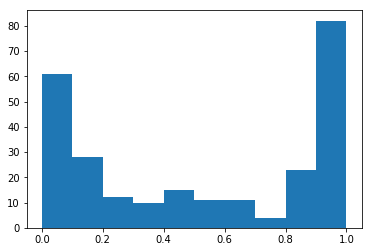

In [99]:
plt.hist(np.vstack(probs));

In [101]:
from sklearn.metrics import f1_score , confusion_matrix , accuracy_score , precision_score , recall_score , roc_auc_score

In [108]:
f1_score(y_valid.data.cpu().numpy() ,np.vstack(test_preds)) , accuracy_score(y_valid.data.cpu().numpy() ,np.vstack(test_preds))

(0.823076923076923, 0.8210116731517509)

In [110]:
test_preds = []
true_label = []
with torch.no_grad():
    for x ,y  in test_dl:
        predictions = model3(x)#.squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))  #torch.round
        preds = rounded_preds.data.cpu().numpy()
        test_preds.append(preds)
        true_label.append(y.data.cpu().numpy())
print('f1 score camera',f1_score(y_test.data.cpu().numpy() ,np.vstack(test_preds)) )
print('accuracy score camera',accuracy_score(y_test.data.cpu().numpy() ,np.vstack(test_preds)))

f1 score camera 0.714590747330961
accuracy score camera 0.6814932486100079


In [112]:
y_test2.shape

torch.Size([1333, 1])

In [114]:
test_preds = []
true_label = []
probs = []
with torch.no_grad():
    for x ,y  in test_dl2:
        predictions = model3(x)#.squeeze(1)
        probs.append(torch.sigmoid(predictions).cpu().numpy())
        rounded_preds = torch.round(torch.sigmoid(predictions))  #torch.round
        preds = rounded_preds.data.cpu().numpy()
        test_preds.append(preds)
        true_label.append(y.data.cpu().numpy())
        
        
print('f1 score mobile',f1_score(y_test2.data.cpu().numpy() ,np.vstack(test_preds)) )
print('accuracy score mobile',accuracy_score(y_test2.data.cpu().numpy() ,np.vstack(test_preds)))

f1 score mobile 0.7232472324723248
accuracy score mobile 0.7186796699174793


In [118]:
confusion_matrix(y_test2.data.cpu().numpy() ,np.vstack(test_preds))

array([[468, 107],
       [268, 490]])

In [92]:
aspects = mlb.classes_.tolist()
"""
Merging prediction value with original test data and observe the metrics on overall level
"""
camera_pred = pd.DataFrame(np.vstack(test_preds) ,index=zu_camera_df.index , columns= [a+'_pred' for a in aspects])
camera_pred2 = pd.merge(zu_camera_df, camera_pred , left_index=True ,right_index = True)

print("F1 score",f1_score( zh_camera, camera_pred2[[a+'_pred' for a in aspects]].as_matrix() , average='macro' ))
print("Accuracy score" , np.mean(zh_camera == camera_pred2[[a+'_pred' for a in aspects]].as_matrix()))

F1 score 0.7018094546534963
Accuracy score 0.7073073868149324


/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [93]:
test_preds = []
true_label = []
with torch.no_grad():
    for x ,y  in test_dl2:
        predictions = model(x)#.squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(predictions))  #torch.round
        preds = rounded_preds.data.cpu().numpy()
        test_preds.append(preds)
        true_label.append(y.data.cpu().numpy())
        
        
aspects = mlb.classes_.tolist()
"""
Merging prediction value with original test data and observe the metrics on overall level
"""
mobile_pred = pd.DataFrame(np.vstack(test_preds) ,index=zu_mobile_df.index , columns= [a+'_pred' for a in aspects])
mobile_pred2 = pd.merge(zu_mobile_df, mobile_pred , left_index=True ,right_index = True)

from sklearn.metrics import f1_score , confusion_matrix , accuracy_score , precision_score , recall_score , roc_auc_score

print("F1 score",f1_score(zh_mobile , mobile_pred2[[a+'_pred' for a in aspects]].as_matrix() , average='macro' ))
print("Accuracy score" , np.mean(zh_mobile == mobile_pred2[[a+'_pred' for a in aspects]].as_matrix()))

F1 score 0.765655739367348
Accuracy score 0.7663165791447862


/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/FRACTAL/swati.tiwari/anaconda3/envs/fastai38/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
